In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
## reading exported csv

# to get csv - save 'BEAM Deploy Status and Run Data' as csv
# if there is not enough permissions - save a copy and then save as csv

data = pd.read_csv("../../../beam-production/jupyter/local_files/BEAM Deploy Status and Run Data - BEAM Instances.csv", parse_dates=['Time'])

# using only runs from specific data 
min_time = pd.to_datetime("2022-07-01") # yyyy-mm-dd
data = data[data['Time'] > min_time].copy()

print(f"there are roughly {len(data) / 2} runs since {min_time}")
print(f"the latest run is from {data['Time'].max()}")

data['Month Period'] = data['Time'].dt.strftime('%Y-%m')
print(f"following data periods are included: {sorted(data['Month Period'].unique())}")

data.head(3)

there are roughly 160.5 runs since 2022-07-01 00:00:00
the latest run is from 2022-07-19 03:21:35
following data periods are included: ['2022-07']


,Status,Run Name,Instance ID,Instance type,Time,Host name,Web browser,Region,Batch,Branch,Commit,Data Branch,Data Commit,S3 Url,Config,Max RAM,Stacktrace,Died Actor,Error,Warning,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Month Period
13629,Run Started,new-york-calibration-300k-16_zneedellATgmail_com,i-0dd2e835f926d1207,r5d.24xlarge,2022-07-01 20:28:38,ec2-18-118-24-240.us-east-2.compute.amazonaws.com,http://ec2-18-118-24-240.us-east-2.compute.ama...,us-east-2,a0838972,inm/nyc-code-change-with-plans-generation,b72992a28c01f828ff976d95aba0ce3d93d6530c,update-calibration,9024d445129599dedf6f749294e4c0306d436d54,NaN,production/newyork/new-york-calibration-16.conf,753,NaN,NaN,NaN,NaN,LVJBLBUUDVULXEAGEQVKUNHZEUSLBDYHEQBIMKEURFEKDWMA,EZLHTZTCVNWIKGTTTEWYXIILFYAMVGSUVIBVYPOHNAZPVEJK,NaN,NaN,2022-07
13630,Run Completed,new-york-calibration-300k-16_zneedellATgmail_com,i-0dd2e835f926d1207,r5d.24xlarge,2022-07-01 20:32:33,ec2-18-118-24-240.us-east-2.compute.amazonaws.com,http://ec2-18-118-24-240.us-east-2.compute.ama...,us-east-2,a0838972,inm/nyc-code-change-with-plans-generation,b72992a28c01f828ff976d95aba0ce3d93d6530c,update-calibration,9024d445129599dedf6f749294e4c0306d436d54,https://s3.us-east-2.amazonaws.com/beam-outpu...,production/newyork/new-york-calibration-16.conf,753,NaN,NaN,NaN,NaN,LVJBLBUUDVULXEAGEQVKUNHZEUSLBDYHEQBIMKEURFEKDWMA,EZLHTZTCVNWIKGTTTEWYXIILFYAMVGSUVIBVYPOHNAZPVEJK,NaN,NaN,2022-07
13631,Run Started,new-york-calibration-300k-16_zneedellATgmail_com,i-0b5b0d2f8a9206efd,r5d.24xlarge,2022-07-01 20:54:18,ec2-3-128-199-112.us-east-2.compute.amazonaws.com,http://ec2-3-128-199-112.us-east-2.compute.ama...,us-east-2,471abd79,inm/nyc-code-change-with-plans-generation,b72992a28c01f828ff976d95aba0ce3d93d6530c,develop,acd91d0626ce8ae634d3d87425669a019ae1089f,NaN,production/newyork/new-york-calibration-16.conf,753,NaN,NaN,NaN,NaN,LVJBLBUUDVULXEAGEQVKUNHZEUSLBDYHEQBIMKEURFEKDWMA,EZLHTZTCVNWIKGTTTEWYXIILFYAMVGSUVIBVYPOHNAZPVEJK,NaN,NaN,2022-07


In [3]:
## getting data frame with each row as one simulation

take_first_columns = ['Run Name','Month Period','Branch','Instance type']

df = data.groupby("Host name").agg(list)
for col in take_first_columns:
    df[col] = df.apply(lambda r: r[col][0], axis=1)
    
df['Time Start'] = df.apply(lambda r: r['Time'][0], axis=1)
df['Time Stop'] = df.apply(lambda r: r['Time'][-1], axis=1)

df['Time Start'] = df['Time Start'].dt.floor('min')
df['Time Stop'] = df['Time Stop'].dt.floor('min')

all_columns = set(df.columns)
taken_columns = take_first_columns + ['Time Start','Time Stop']
df = df[taken_columns].copy()

print(f"removed columns: {list(sorted(all_columns - set(taken_columns)))}")

# fix for some wierd shift in the spreadsheet for few rows
for v in ['ec2-18-221-208-40.us-east-2.compute.amazonaws.com','ec2-3-144-69-95.us-east-2.compute.amazonaws.com','ec2-52-15-53-101.us-east-2.compute.amazonaws.com']:
    df.replace(to_replace=v, value='r5d.24xlarge', inplace=True)

print(f"there are following instance types used: {list(df['Instance type'].unique())}")
    
df['duration_minutes'] = (df['Time Stop'] - df['Time Start']).astype('timedelta64[m]')
df['duration_minutes'] = df.apply(lambda r: max(r['duration_minutes'], 1.0), axis=1)

df.head(3)

removed columns: ['Batch', 'Commit', 'Config', 'Data Branch', 'Data Commit', 'Died Actor', 'Error', 'Instance ID', 'Max RAM', 'Region', 'S3 Url', 'Stacktrace', 'Status', 'Time', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Warning', 'Web browser']
there are following instance types used: ['r5d.24xlarge', 'r5.2xlarge', 'r5.24xlarge', 'c5.9xlarge']


,Run Name,Month Period,Branch,Instance type,Time Start,Time Stop,duration_minutes
Host name,,,,,,,
ec2-13-58-126-202.us-east-2.compute.amazonaws.com,0.1pop-testing-new-gtfs_j503440616ATberkeley_edu,2022-07,Xuan/micromobility-without-tour-mode-sfbay,r5d.24xlarge,2022-07-12 22:06:00,2022-07-12 22:06:00,1.0
ec2-13-59-202-167.us-east-2.compute.amazonaws.com,alex-vv/test-jupyter-deploy-2_avflanceATgmail_com,2022-07,develop,r5.2xlarge,2022-07-06 16:18:00,2022-07-06 16:24:00,6.0
ec2-13-59-221-115.us-east-2.compute.amazonaws.com,inm/cpu_ram_logging_irishwithaxeATgmail_com,2022-07,inm/cpu_ram_logging_on_aws,r5.2xlarge,2022-07-05 09:48:00,2022-07-05 12:12:00,144.0


In [4]:
## calculating a price in USD of each simulation

instance_to_price = {'r5d.24xlarge':6.912, 
                     'm5d.24xlarge':5.424, 
                     'r5.xlarge':0.252, 
                     'r5.24xlarge':6.048,
                     'r5.8xlarge':2.016, 
                     'm5.24xlarge':4.608, 
                     'r5.2xlarge':0.504, 
                     'm4.16xlarge':3.20,
                     'c5.9xlarge':1.53
                    }

missing_instance_types = set()
def get_price(row):
    instance_type = row['Instance type']
    if instance_type in instance_to_price :
        return instance_to_price[instance_type]

    missing_instance_types.add(instance_type)
    return 0.0

df['aws_cost'] = df.apply(get_price, axis=1)

if len(missing_instance_types) > 0:
    print(f"Can't find price for following instances: {missing_instance_types}")
    
df['cost'] = df['duration_minutes'] * df['aws_cost'] / 60.0
total_cost = int(df['cost'].sum())
print(f"The total cost of all instances from df: {total_cost}")
df.head(3)

The total cost of all instances from df: 4919


,Run Name,Month Period,Branch,Instance type,Time Start,Time Stop,duration_minutes,aws_cost,cost
Host name,,,,,,,,,
ec2-13-58-126-202.us-east-2.compute.amazonaws.com,0.1pop-testing-new-gtfs_j503440616ATberkeley_edu,2022-07,Xuan/micromobility-without-tour-mode-sfbay,r5d.24xlarge,2022-07-12 22:06:00,2022-07-12 22:06:00,1.0,6.912,0.1152
ec2-13-59-202-167.us-east-2.compute.amazonaws.com,alex-vv/test-jupyter-deploy-2_avflanceATgmail_com,2022-07,develop,r5.2xlarge,2022-07-06 16:18:00,2022-07-06 16:24:00,6.0,0.504,0.0504
ec2-13-59-221-115.us-east-2.compute.amazonaws.com,inm/cpu_ram_logging_irishwithaxeATgmail_com,2022-07,inm/cpu_ram_logging_on_aws,r5.2xlarge,2022-07-05 09:48:00,2022-07-05 12:12:00,144.0,0.504,1.2096


In [5]:
## grouping simulations by something

def get_owner(row):
    run_name = row['Run Name']
    if '/' in run_name:
        return run_name.split('/')[0]
    return "??"

# df['owner of run'] = df.apply(get_owner, axis=1)

def get_branch_owner(row):
    branch = row['Branch'].split('/')
    if len(branch) > 1:
        return branch[0]
    return "??"

def get_project(row):
    owner = get_owner(row)
    branch_owner = get_branch_owner(row)
    return f"{owner} | {branch_owner}"
    

df["project"] = df.apply(get_project, axis=1)
df.reset_index(inplace=True)
df_sum = (df.groupby("project")['cost'].sum() / total_cost).reset_index().sort_values("cost", ascending=False)
df_sum

,project,cost
3,?? | inm,0.682886
1,?? | Xuan,0.097284
4,?? | zn,0.082858
2,?? | hl,0.063115
6,inm | inm,0.049881
0,?? | ??,0.023891
5,alex-vv | ??,0.000101


In [6]:
def get_intervals(row):
    d_from = row['Time Start']
    d_to = row['Time Stop']
    return pd.date_range(start=d_from, end=d_to, freq='min')
    
df['intervals'] = df.apply(get_intervals, axis=1)
df1 = df.explode('intervals').reset_index(drop=True)
df1.rename(columns={'intervals': 'Time'}, inplace=True)
df1['Date'] = df1['Time'].dt.floor('d')
print(df.shape, df1.shape)
df1.head(3)

(179, 12) (43415, 13)


,Host name,Run Name,Month Period,Branch,Instance type,Time Start,Time Stop,duration_minutes,aws_cost,cost,project,Time,Date
0,ec2-13-58-126-202.us-east-2.compute.amazonaws.com,0.1pop-testing-new-gtfs_j503440616ATberkeley_edu,2022-07,Xuan/micromobility-without-tour-mode-sfbay,r5d.24xlarge,2022-07-12 22:06:00,2022-07-12 22:06:00,1.0,6.912,0.1152,?? | Xuan,2022-07-12 22:06:00,2022-07-12
1,ec2-13-59-202-167.us-east-2.compute.amazonaws.com,alex-vv/test-jupyter-deploy-2_avflanceATgmail_com,2022-07,develop,r5.2xlarge,2022-07-06 16:18:00,2022-07-06 16:24:00,6.0,0.504,0.0504,alex-vv | ??,2022-07-06 16:18:00,2022-07-06
2,ec2-13-59-202-167.us-east-2.compute.amazonaws.com,alex-vv/test-jupyter-deploy-2_avflanceATgmail_com,2022-07,develop,r5.2xlarge,2022-07-06 16:18:00,2022-07-06 16:24:00,6.0,0.504,0.0504,alex-vv | ??,2022-07-06 16:19:00,2022-07-06


<AxesSubplot:xlabel='Date'>

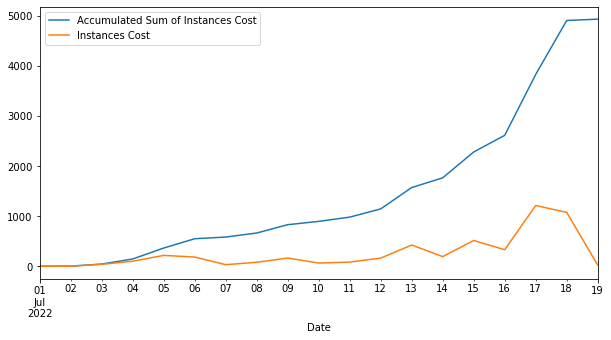

In [7]:
date_col = 'Date'
acc_col_name = 'Accumulated Sum of Instances Cost'
cost_col_name = 'Instances Cost'

df2 = df1.groupby(date_col)['aws_cost'].agg(sum).reset_index()

# because minutes intervals are used
df2['aws_cost'] = df2['aws_cost'] / 60.0

df2.rename(columns={'aws_cost': cost_col_name}, inplace=True)

df2[acc_col_name] = np.cumsum(df2[cost_col_name])
ax = df2.plot(x=date_col, y=acc_col_name, figsize=(10,5))
df2.plot(x=date_col, y=cost_col_name, ax = ax)
